In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
transform = transforms.ToTensor()

mnist_data = datasets.MNIST('./data', train=True, 
                            download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data, 
                                          batch_size=64, 
                                          shuffle=True)

In [3]:
dataiter = iter(data_loader)
images, labels = next(dataiter)
print(images.shape)
print(torch.min(images), torch.max(images))

torch.Size([64, 1, 28, 28])
tensor(0.) tensor(1.)


In [4]:
class Autoencoder_Linear(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128), # fully connected layer reduces from 28*28 -> 128
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3) # We have reduced from 28*28 -> 3 latent dimensions/features
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid() # This is transform decoded output into original [0,1] range
            # if original space is -1 to 1, then use nn.Tanh()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded    

In [ ]:
class Autoencoder_Conv(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid() # This is transform decoded output into original [0,1] range
            # if original space is -1 to 1, then use nn.Tanh()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded    

In [5]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [6]:
 num_epochs = 10
 outputs = []
 for epoch in range(num_epochs):
    for (image, _) in data_loader:
        #  image = image.reshape(-1, 28*28) # flattening into 1D array
         recon = model(image)
         loss = criterion(recon, image)
         
         optimizer.zero_grad()
         loss.backward()
         optimizer.step()
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
#     print(image.shape)
    outputs.append((epoch, image, recon))

Epoch:1, Loss:0.0446
Epoch:2, Loss:0.0437
Epoch:3, Loss:0.0379
Epoch:4, Loss:0.0376
Epoch:5, Loss:0.0368
Epoch:6, Loss:0.0320
Epoch:7, Loss:0.0357
Epoch:8, Loss:0.0391
Epoch:9, Loss:0.0392
Epoch:10, Loss:0.0375


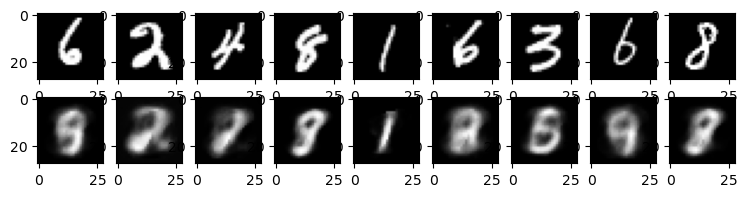

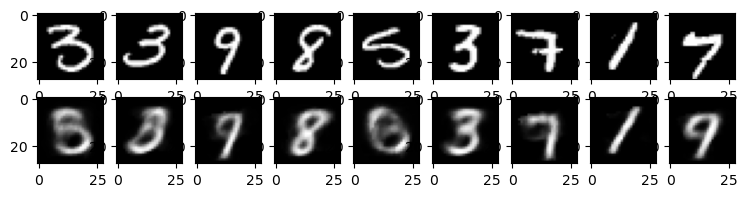

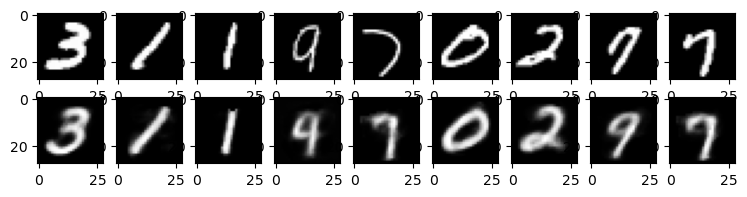

In [7]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # # item: 1, 28, 28
        plt.imshow(item[0])